In [2]:
import numpy as np
import pandas as pd
import emcee
import corner
from scipy.optimize import minimize
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt

In [3]:
%matplotlib notebook

In [375]:
sn = 'ZTF18aawpcel'
lc_df = pd.read_hdf("../../forced_lightcurves/sample_lc_v2//{}_force_phot.h5".format(sn))
salt_df = pd.read_csv("../../Nobs_cut_salt2_spec_subtype.csv")

In [376]:
lc_df.fcqfid.unique()

array([8200212., 8200211.])

In [377]:
lc_df.head()

jdobs filter  seeing      gain      zp       ezp  programid  \
10  2.458222e+06   b'r'   3.439  5.022017  26.275  0.000028        2.0   
11  2.458222e+06   b'r'   3.955  5.309314  26.275  0.000030        2.0   
0   2.458222e+06   b'r'   3.785  5.342597  26.275  0.000030        1.0   
12  2.458223e+06   b'r'   2.970  5.738585  26.275  0.000022        2.0   
13  2.458223e+06   b'r'   3.455  5.730598  26.275  0.000025        2.0   

    fieldid  ccdid  qid    ...         Fmcmc  Fmcmc_unc        Fratio  \
10    820.0    2.0  1.0    ...      8.468934  41.804622  2.617151e-10   
11    820.0    2.0  1.0    ...    -47.371298  43.365148 -1.463913e-09   
0     820.0    2.0  1.0    ...     16.923289  42.970177  5.229796e-10   
12    820.0    2.0  1.0    ...     27.562934  37.959748  8.517761e-10   
13    820.0    2.0  1.0    ...     -4.675920  44.072962 -1.444998e-10   

      Fratio_unc   jdref_start     jdref_end     fcqfid  scisigpix    offset  \
10  1.291886e-09  2.458183e+06  2.458220e+06  8200212.0    7.92435 -6.459411   
11  1.340111e-09  2.458183e+06  2.458220e+06  8200212.0    7.00618 -6.459411   
0   1.327905e-09  2.458183e+06  2.458220e+06  8200212.0    6.87100 -6.459411   
12  1.173068e-09  2.458183e+06  2.458220e+06  8200212.0    6.31395 -6.459411   
13  1.361985e-09  2.458183e+06  2.458220e+06  8200212.0    6.32260 -6.459411   

    multiply  
10  0.817378  
11  0.817378  
0   0.817378  
12  0.817378  
13  0.817378  

[5 rows x 32 columns]

<IPython.core.display.Javascript object>


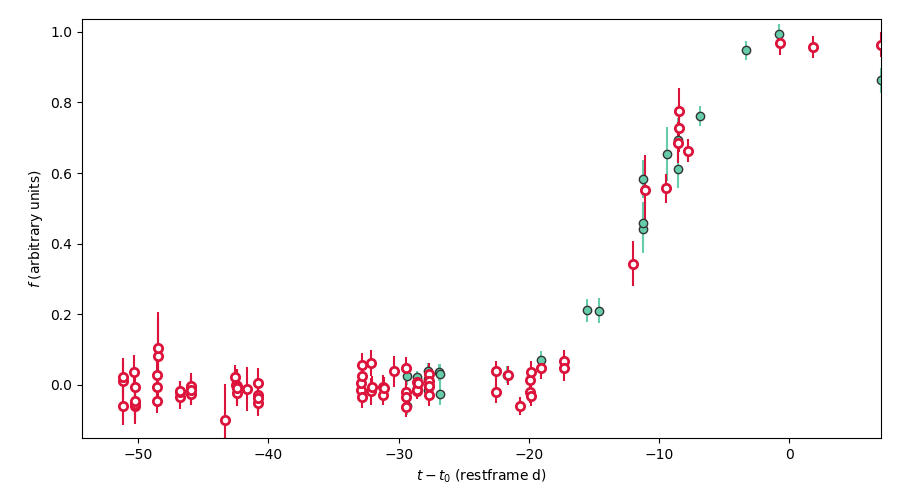

In [378]:
g_obs = np.where((lc_df['filter'] == b'g'))
r_obs = np.where((lc_df['filter'] == b'r'))

t0 = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

fig, ax = plt.subplots(figsize=(9,5))
ax.errorbar((lc_df['jdobs'].iloc[g_obs] - t0)/(1+z), 
            lc_df['Fratio'].iloc[g_obs]/g_max,
            lc_df['Fratio_unc'].iloc[g_obs]/g_max, 
            fmt = 'o', color='MediumAquaMarine',
            mec='0.2')
ax.errorbar((lc_df['jdobs'].iloc[r_obs] - t0)/(1+z), 
            lc_df['Fratio'].iloc[r_obs]/r_max,
            lc_df['Fratio_unc'].iloc[r_obs]/r_max, 
            fmt = 'o', mfc='white', ecolor='Crimson',
            mec='Crimson', mew=2)
ax.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
ax.set_ylabel('$f \; (\mathrm{arbitrary \; units})$')
fig.tight_layout()

# ax.set_xlim(-75,90)
# ax.set_xlabel('$t - t_\mathrm{peak} \; (\mathrm{d})$', fontsize=18)
# ax.set_ylabel(' ', fontsize=18)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set_yticklabels([])
# ax.tick_params(left=False, labelsize=14)
# fig.subplots_adjust(left=0.01,right=0.99,top=0.99)
# fig.savefig('Ia_lc.png', transparent=True)

In [8]:
def f_t(times, amplitude=25, t_0=0, alpha_r=2):
    
    return amplitude * (times - t_0)**alpha_r

In [9]:
def plot_both_filt(theta, t, f, f_unc, filt_arr,
                   t0=-18):

    color_dict = {b'r': 'Crimson',
                  b'g': 'MediumAquaMarine'}
    offset_dict = {b'r': -0.1,
                  b'g': 0.1}
    mark_color_dict = {b'r': 'white',
                  b'g': 'MediumAquaMarine'}
    sym_dict = {b'r': 'o',
                b'g': 'o'}
    mec_dict = {b'r': 'Crimson',
                b'g': '0.5'}
    mew_dict = {b'r': 2,
                b'g': 0.5}
    
    if len(theta) % 3 != 1:
        raise RuntimeError('The correct number of parameters were not included')

    fig = plt.figure()
    axPlot = plt.axes([0.15, 0.37, 0.82, 0.61])
    axRes = plt.axes([0.15, 0.1, 0.82, 0.25], sharex=axPlot)

    for filt_num, filt in enumerate(np.unique(filt_arr)):
        theta_filt = np.append(theta[0], theta[1+3*filt_num:4+3*filt_num])
        filt_obs = np.where(filt_arr == filt)
        f_filt = f[filt_obs]
        t_filt = t[filt_obs]
        f_err_filt = f_unc[filt_obs]

        half_max = ((f_filt < 0.5) & (t_filt < 0))

    
        t_post = np.linspace(theta[0], 80, 1000)
        t_pre = np.linspace(min(t_filt), theta[0], 1000)
        model_flux = theta_filt[1] + f_t(t_post, theta_filt[2], theta_filt[0], theta_filt[3])

        axPlot.errorbar(t_filt[half_max], f_filt[half_max] + offset_dict[filt], f_err_filt[half_max],
                    fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                    mec=mec_dict[filt], mew=mew_dict[filt])
        axPlot.errorbar(t_filt[~half_max], f_filt[~half_max] + offset_dict[filt], f_err_filt[~half_max],
                    fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                    mec=mec_dict[filt], mew=mew_dict[filt], alpha=0.2)
        axPlot.plot(t_post, model_flux + offset_dict[filt], color=color_dict[filt], zorder=10)
        axPlot.plot(t_pre, np.ones_like(t_pre)*theta_filt[1] + offset_dict[filt], color=color_dict[filt], zorder=10)
#         axPlot.plot([max(t_filt[half_max]),max(t_filt[half_max])], [-50,50], 
#                    '--', color=color_dict[filt])
        axPlot.set_xlim(-30, 3)
        axPlot.set_ylim(min(f_filt[half_max])-0.15, 1.2)
#         axPlot.set_xticklabels([])

        after_exp = t_filt >= theta_filt[0]

        residuals = np.append(f_filt[~after_exp] - theta_filt[1], 
                              f_filt[after_exp] - (theta_filt[1] + f_t(t_filt[after_exp], theta_filt[2], theta_filt[0], theta_filt[3]))  
                             )

        axRes.errorbar(t_filt[half_max], residuals[half_max] + offset_dict[filt], f_err_filt[half_max],
                       fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                       mec=mec_dict[filt], mew=mew_dict[filt])
        axRes.errorbar(t_filt[~half_max], residuals[~half_max] + offset_dict[filt], f_err_filt[~half_max],
                       fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                       mec=mec_dict[filt], mew=mew_dict[filt], alpha=0.2)
        axRes.plot([-5000,10000], [offset_dict[filt], offset_dict[filt]], '-', color=color_dict[filt])
#         axRes.plot([max(t_filt[half_max]),max(t_filt[half_max])], [-50,50], 
#                    '--', color=color_dict[filt])
        axRes.set_xlim(-30, 3)
        axRes.set_ylim(min(residuals[half_max]) - 0.1, max(residuals[half_max]) + 0.1)
        axRes.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
        axPlot.set_ylabel('$f \; (\mathrm{aribitrary \; units})$')

    if t0 != -18:
        axPlot.plot([t0,t0], [-50,50], 
               '--', color='0.8', lw=0.5)
        axRes.plot([t0,t0], [-50,50], 
               '--', color='0.8', lw=0.5)

    return

In [54]:
def lnlike_simple(theta, f, t, f_err):
    t_0, a, a_prime, alpha_r = theta
    
    pre_exp = np.logical_not(t > t_0)
    model = 999*np.ones_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r
    assert np.all(model < 999),'fewer model values than flux values'
    
    ln_l = -0.5*np.sum((f - model)**2 / (f_err**2))
    return ln_l

def nll_simple(theta, f, t, f_err):
    return -1*lnlike_simple(theta, f, t, f_err)

#Define priors on parameters  
def lnprior_simple(theta):
    t_0, a, a_prime, alpha_r = theta
    if (-1e8 < t_0 < 1e8 and 0 < alpha_r < 1e8 and 
        -1e8 < a < 1e8 and 
        0 < a_prime < 1e8):
        return 0.0
    return -np.inf

def lnposterior_simple(theta, f, t, f_err):
    lnp = lnprior_simple(theta)
    lnl = lnlike_simple(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp

## Fit multiple filters for $t_\mathrm{fl}$ and $\alpha_r$

Given that there are multiple fcqfid per filter in some cases, the value of the baseline needs to be fit for separately for each of the filters. This requires more than the 2 filter solution that was used previously. To accomodate this change, the definition of theta needs to be adjusted (to account for multiple filters, some with extra fcqid:

theta = t_0, A_g, alpha_g, A_r, alpha_r, [A_i, alpha_i], a1_g, a1_r, a1_i, a2_g, a2_r, .... (increasing for however many fcqfid there are)

In [57]:
def multifcqfid_lnlike_simple(theta, f, t, f_err, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))
    
    if len(theta) != 1 + 2*n_filt + n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')
    
    ln_l = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)
                
        theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + fcqfid_num], 
                                 theta[2*filt-1], theta[2*filt]])
        fcqfid_obs = np.where(fcqfid_arr == fcqfid)
        f_fcqfid = f[fcqfid_obs]
        t_fcqfid = t[fcqfid_obs]
        f_err_fcqfid = f_err[fcqfid_obs]
        ln_l += lnlike_simple(theta_fcqfid, f_fcqfid, t_fcqfid, f_err_fcqfid)
    
    return ln_l

def multifcqfid_nll_simple(theta, f, t, f_err, fcqfid_arr):
    return -1*multifcqfid_lnlike_simple(theta, f, t, f_err, fcqfid_arr)

def multifcqfid_lnprior_simple(theta, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))
    
    if len(theta) != 1 + 2*n_filt + n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')
    
    ln_p = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)
                
        theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + fcqfid_num], 
                                 theta[2*filt-1], theta[2*filt]])
        ln_p += lnprior_simple(theta_fcqfid)
    return ln_p

def multifcqfid_lnposterior_simple(theta, f, t, f_err, fcqfid_arr):
    lnp = multifcqfid_lnprior_simple(theta, fcqfid_arr)
    lnl = multifcqfid_lnlike_simple(theta, f, t, f_err, fcqfid_arr)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp

In [13]:
rel_flux_cutoff = 0.5

time_rf = (lc_df['jdobs'].iloc[obs].values - t0)/(1+z)
flux = lc_df['Fratio'].iloc[obs].values
g_max = np.max(lc_df['Fratio'].iloc[g_obs].values)
r_max = np.max(lc_df['Fratio'].iloc[g_obs].values)
flux[g_obs] = flux[g_obs]/g_max
flux[r_obs] = flux[r_obs]/r_max
flux_unc = lc_df['Fratio_unc'].iloc[obs].values
flux_unc[g_obs] = flux_unc[g_obs]/g_max
flux_unc[r_obs] = flux_unc[r_obs]/r_max
fcqfid_arr = lc_df['fcqfid'].iloc[obs].values

t_fl = 18

cutoff_g = np.where((time_rf[g_obs] < 0) & 
                   (flux[g_obs] < rel_flux_cutoff))
t_cut_g = time_rf[g_obs][cutoff_g[0][-1]] + 0.5
early_g = np.where(time_rf[g_obs] < t_cut_g)
cutoff_r = np.where((time_rf[r_obs] < 0) & 
                   (flux[r_obs] < rel_flux_cutoff))
t_cut_r = time_rf[r_obs][cutoff_r[0][-1]] + 0.5
early_r = np.where(time_rf[r_obs] < t_cut_r)
early_obs = np.append(g_obs[0][early_g], r_obs[0][early_r])

f_data = flux[early_obs]
t_data = time_rf[early_obs]
f_unc_data = flux_unc[early_obs]
fcqfid_data = fcqfid_arr[early_obs]

n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))
guess_0 = np.append([-t_fl] + [6e-3, 2]*n_filt,
                    np.zeros(len(np.unique(fcqfid_data))))


print(multifcqfid_nll_simple(guess_0, flux, time_rf, flux_unc, fcqfid_data))

NameError: name 'multifcqfid_nll_big_unc' is not defined

In [59]:
# initialize near maximum-likelihood result
ml_res = minimize(multifcqfid_nll_simple, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(f_data, t_data, f_unc_data, fcqfid_data))
ml_guess = ml_res.x
print(ml_guess)
print(multifcqfid_nll_simple(ml_guess, f_data, t_data, f_unc_data, fcqfid_data))

[-1.94656183e+01  1.33655254e-03  2.51804288e+00  1.99654512e-03
  2.32202931e+00 -2.22851163e-04  3.15924635e-04]
136.79844856296114


In [60]:
###################################
###  sample without sig_0 term  ###
###################################


nwalkers = 100
ndim = len(ml_guess)
nfac = [1e-4]*ndim

#initial position of walkers
pos = [ml_guess + ml_guess * nfac * np.random.randn(ndim) for i in range(nwalkers)]

filename = 'tmp.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)        


with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, multifcqfid_lnposterior_simple, 
                                    args=(f_data, t_data, f_unc_data, fcqfid_data),
                                    pool=pool, backend=backend)
    max_samples = 120
    index = 0
    autocorr = np.empty(max_samples)
    old_tau = np.inf
    check_tau = 6
    for sample in sampler.sample(pos, iterations=max_samples, thin_by=250, progress=True):
        if sampler.iteration % check_tau:
            continue
        
        tstart = time.time()
        tau = sampler.get_autocorr_time(tol=0)
        tend = time.time()
        autocorr[index] = np.mean(tau)
        index += 1
        steps_so_far = index*check_tau
        print('''After {:d} steps, 
autocorrelation takes {:.3f} s ({} total FFTs)                
acceptance fraction = {:.4f}, and
tau = {}'''.format(steps_so_far, 
                   tend-tstart, nwalkers*ndim,
                   np.mean(sampler.acceptance_fraction), 
                   tau))

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

  5%|▌         | 1519/30000 [00:12<03:52, 122.26it/s]

After 6 steps, 
autocorrelation takes 0.031 s (700 total FFTs)                
acceptance fraction = 0.3683, and
tau = [0.26148207 0.26515566 0.2676468  0.28032662 0.28483673 0.32630376
 0.36500846]


 10%|█         | 3021/30000 [00:24<04:07, 108.99it/s]

After 12 steps, 
autocorrelation takes 0.028 s (700 total FFTs)                
acceptance fraction = 0.3600, and
tau = [0.65444072 0.63527017 0.61577177 0.62674886 0.61730823 0.50601241
 0.62153566]


 15%|█▌        | 4515/30000 [00:37<03:47, 112.04it/s]

After 18 steps, 
autocorrelation takes 0.030 s (700 total FFTs)                
acceptance fraction = 0.3494, and
tau = [0.93199607 0.93161738 0.90456401 0.92512976 0.90466894 0.65322414
 0.69844556]


 20%|██        | 6016/30000 [00:50<04:29, 88.94it/s] 

After 24 steps, 
autocorrelation takes 0.042 s (700 total FFTs)                
acceptance fraction = 0.3396, and
tau = [1.09932723 1.1004773  1.06794799 1.11956236 1.10681384 0.76109673
 0.73349187]


 25%|██▌       | 7522/30000 [01:03<03:18, 113.51it/s]

After 30 steps, 
autocorrelation takes 0.031 s (700 total FFTs)                
acceptance fraction = 0.3423, and
tau = [1.26899851 1.27470437 1.25934393 1.26172584 1.25074792 0.79109467
 0.85630981]


 30%|███       | 9014/30000 [01:15<03:09, 110.65it/s]

After 36 steps, 
autocorrelation takes 0.031 s (700 total FFTs)                
acceptance fraction = 0.3439, and
tau = [1.40599197 1.3930842  1.3632992  1.41369731 1.39306459 0.86248487
 0.88893886]


 35%|███▌      | 10519/30000 [01:28<02:56, 110.21it/s]

After 42 steps, 
autocorrelation takes 0.032 s (700 total FFTs)                
acceptance fraction = 0.3402, and
tau = [1.49777093 1.48913011 1.45918385 1.49796469 1.4827257  0.92935163
 0.91089034]


 40%|████      | 12025/30000 [01:41<02:33, 116.84it/s]

After 48 steps, 
autocorrelation takes 0.031 s (700 total FFTs)                
acceptance fraction = 0.3383, and
tau = [1.59955493 1.5820586  1.54183955 1.51927093 1.572503   0.99375776
 0.94034234]


 45%|████▌     | 13524/30000 [01:53<02:30, 109.47it/s]

After 54 steps, 
autocorrelation takes 0.036 s (700 total FFTs)                
acceptance fraction = 0.3409, and
tau = [1.63543772 1.616661   1.56625999 1.63368926 1.601985   0.99385938
 0.9989396 ]


 50%|█████     | 15012/30000 [02:06<02:20, 106.47it/s]

After 60 steps, 
autocorrelation takes 0.032 s (700 total FFTs)                
acceptance fraction = 0.3433, and
tau = [1.79730958 1.77110646 1.72362045 1.78028682 1.75181665 0.9246208
 0.95961818]


 55%|█████▌    | 16515/30000 [02:19<01:56, 115.69it/s]

After 66 steps, 
autocorrelation takes 0.035 s (700 total FFTs)                
acceptance fraction = 0.3435, and
tau = [1.86849921 1.84792851 1.80076033 1.86025935 1.82987412 0.94664362
 0.99326298]


 60%|██████    | 18020/30000 [02:31<01:47, 111.81it/s]

After 72 steps, 
autocorrelation takes 0.035 s (700 total FFTs)                
acceptance fraction = 0.3435, and
tau = [1.89042053 1.88953228 1.8522302  1.88543323 1.85557146 0.93298947
 1.01403237]


 65%|██████▌   | 19524/30000 [02:45<01:36, 109.03it/s]

After 78 steps, 
autocorrelation takes 0.037 s (700 total FFTs)                
acceptance fraction = 0.3444, and
tau = [1.96805939 1.95563443 1.9259082  1.94981037 1.92191442 0.95719853
 1.01894215]


 70%|███████   | 21019/30000 [02:58<01:19, 113.58it/s]

After 84 steps, 
autocorrelation takes 0.033 s (700 total FFTs)                
acceptance fraction = 0.3462, and
tau = [1.99998414 1.9861037  1.96415051 1.98886113 1.96926098 0.97106869
 1.0235512 ]


 75%|███████▌  | 22513/30000 [03:11<01:07, 111.11it/s]

After 90 steps, 
autocorrelation takes 0.032 s (700 total FFTs)                
acceptance fraction = 0.3461, and
tau = [1.99722226 1.99048083 1.96953948 1.98134408 1.96270276 0.9807369
 1.0174261 ]


 80%|████████  | 24015/30000 [03:23<00:53, 111.47it/s]

After 96 steps, 
autocorrelation takes 0.034 s (700 total FFTs)                
acceptance fraction = 0.3466, and
tau = [1.9967698  1.99468689 1.97948963 1.97860914 1.96348337 0.96928616
 1.03322991]


 85%|████████▌ | 25512/30000 [03:36<00:44, 101.37it/s]

After 102 steps, 
autocorrelation takes 0.035 s (700 total FFTs)                
acceptance fraction = 0.3451, and
tau = [1.99095941 1.97181402 1.9606596  1.97611871 1.96354089 0.95441093
 1.03627903]


 90%|█████████ | 27020/30000 [03:49<00:30, 97.64it/s] 

After 108 steps, 
autocorrelation takes 0.035 s (700 total FFTs)                
acceptance fraction = 0.3445, and
tau = [2.0114599  1.97993414 1.96890211 1.99584131 1.98626834 0.98339132
 1.05260261]


 95%|█████████▌| 28526/30000 [04:02<00:12, 115.38it/s]

After 114 steps, 
autocorrelation takes 0.034 s (700 total FFTs)                
acceptance fraction = 0.3448, and
tau = [2.05527156 2.02365991 2.01805377 2.0166618  2.00896364 1.00661877
 1.05163263]


100%|██████████| 30000/30000 [04:14<00:00, 117.75it/s]

After 120 steps, 
autocorrelation takes 0.035 s (700 total FFTs)                
acceptance fraction = 0.3449, and
tau = [2.11144972 2.08300432 2.0826341  2.06809815 2.05941703 1.02036511
 1.04566104]


After 100 steps, 
autocorrelation takes 0.035 s (700 total FFTs)                
acceptance fraction = 0.2732, and
tau = [5.84013413 1.91818081 5.82661309 5.82264879 1.9015862  5.77467252
 5.72451288]

<IPython.core.display.Javascript object>


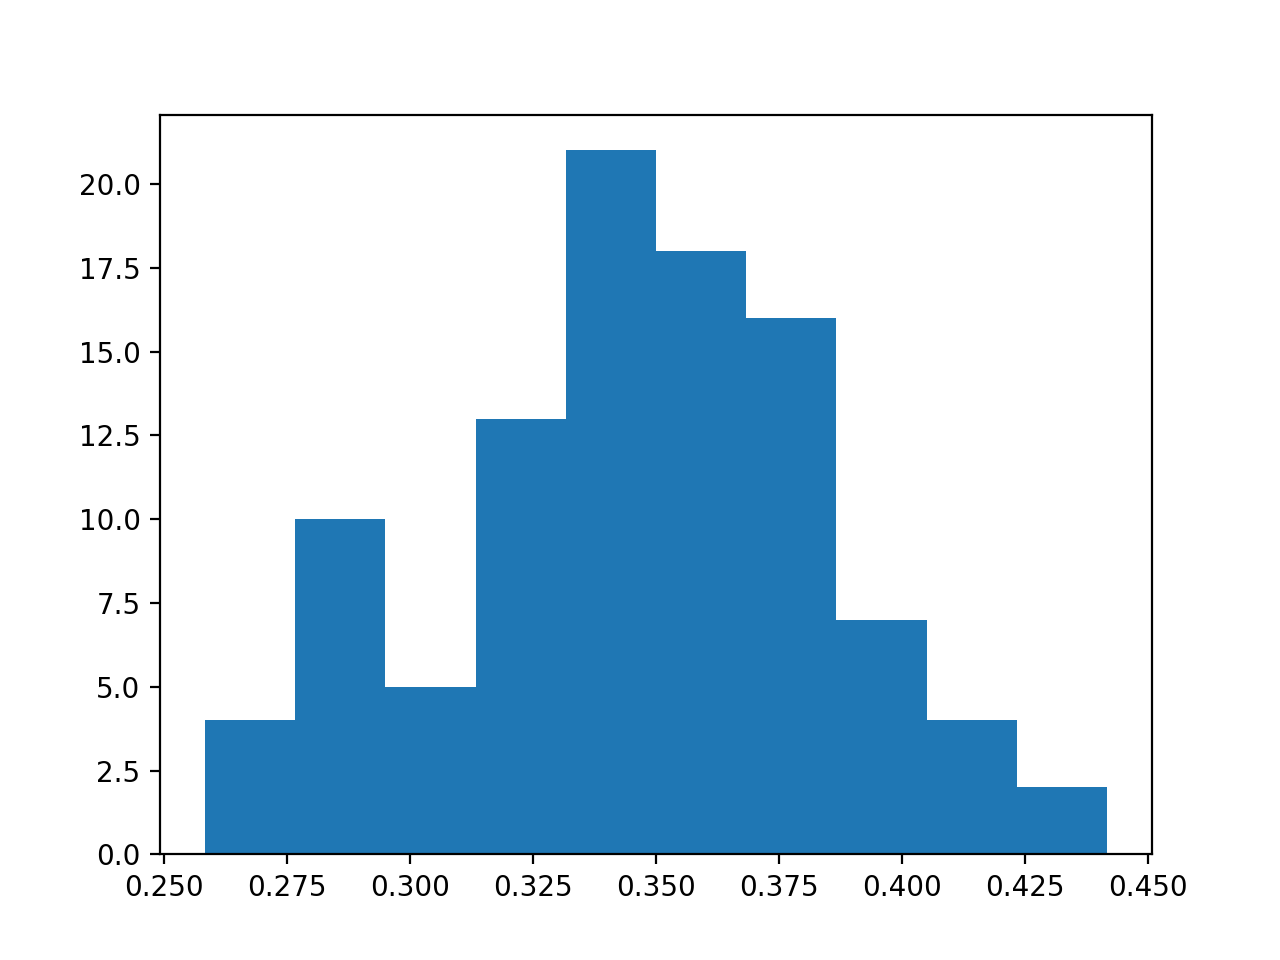

(array([ 4., 10.,  5., 13., 21., 18., 16.,  7.,  4.,  2.]),
 array([0.25833333, 0.27666667, 0.295     , 0.31333333, 0.33166667,
        0.35      , 0.36833333, 0.38666667, 0.405     , 0.42333333,
        0.44166667]),
 <a list of 10 Patch objects>)

In [61]:
plt.figure()
plt.hist(sampler.acceptance_fraction)

<IPython.core.display.Javascript object>


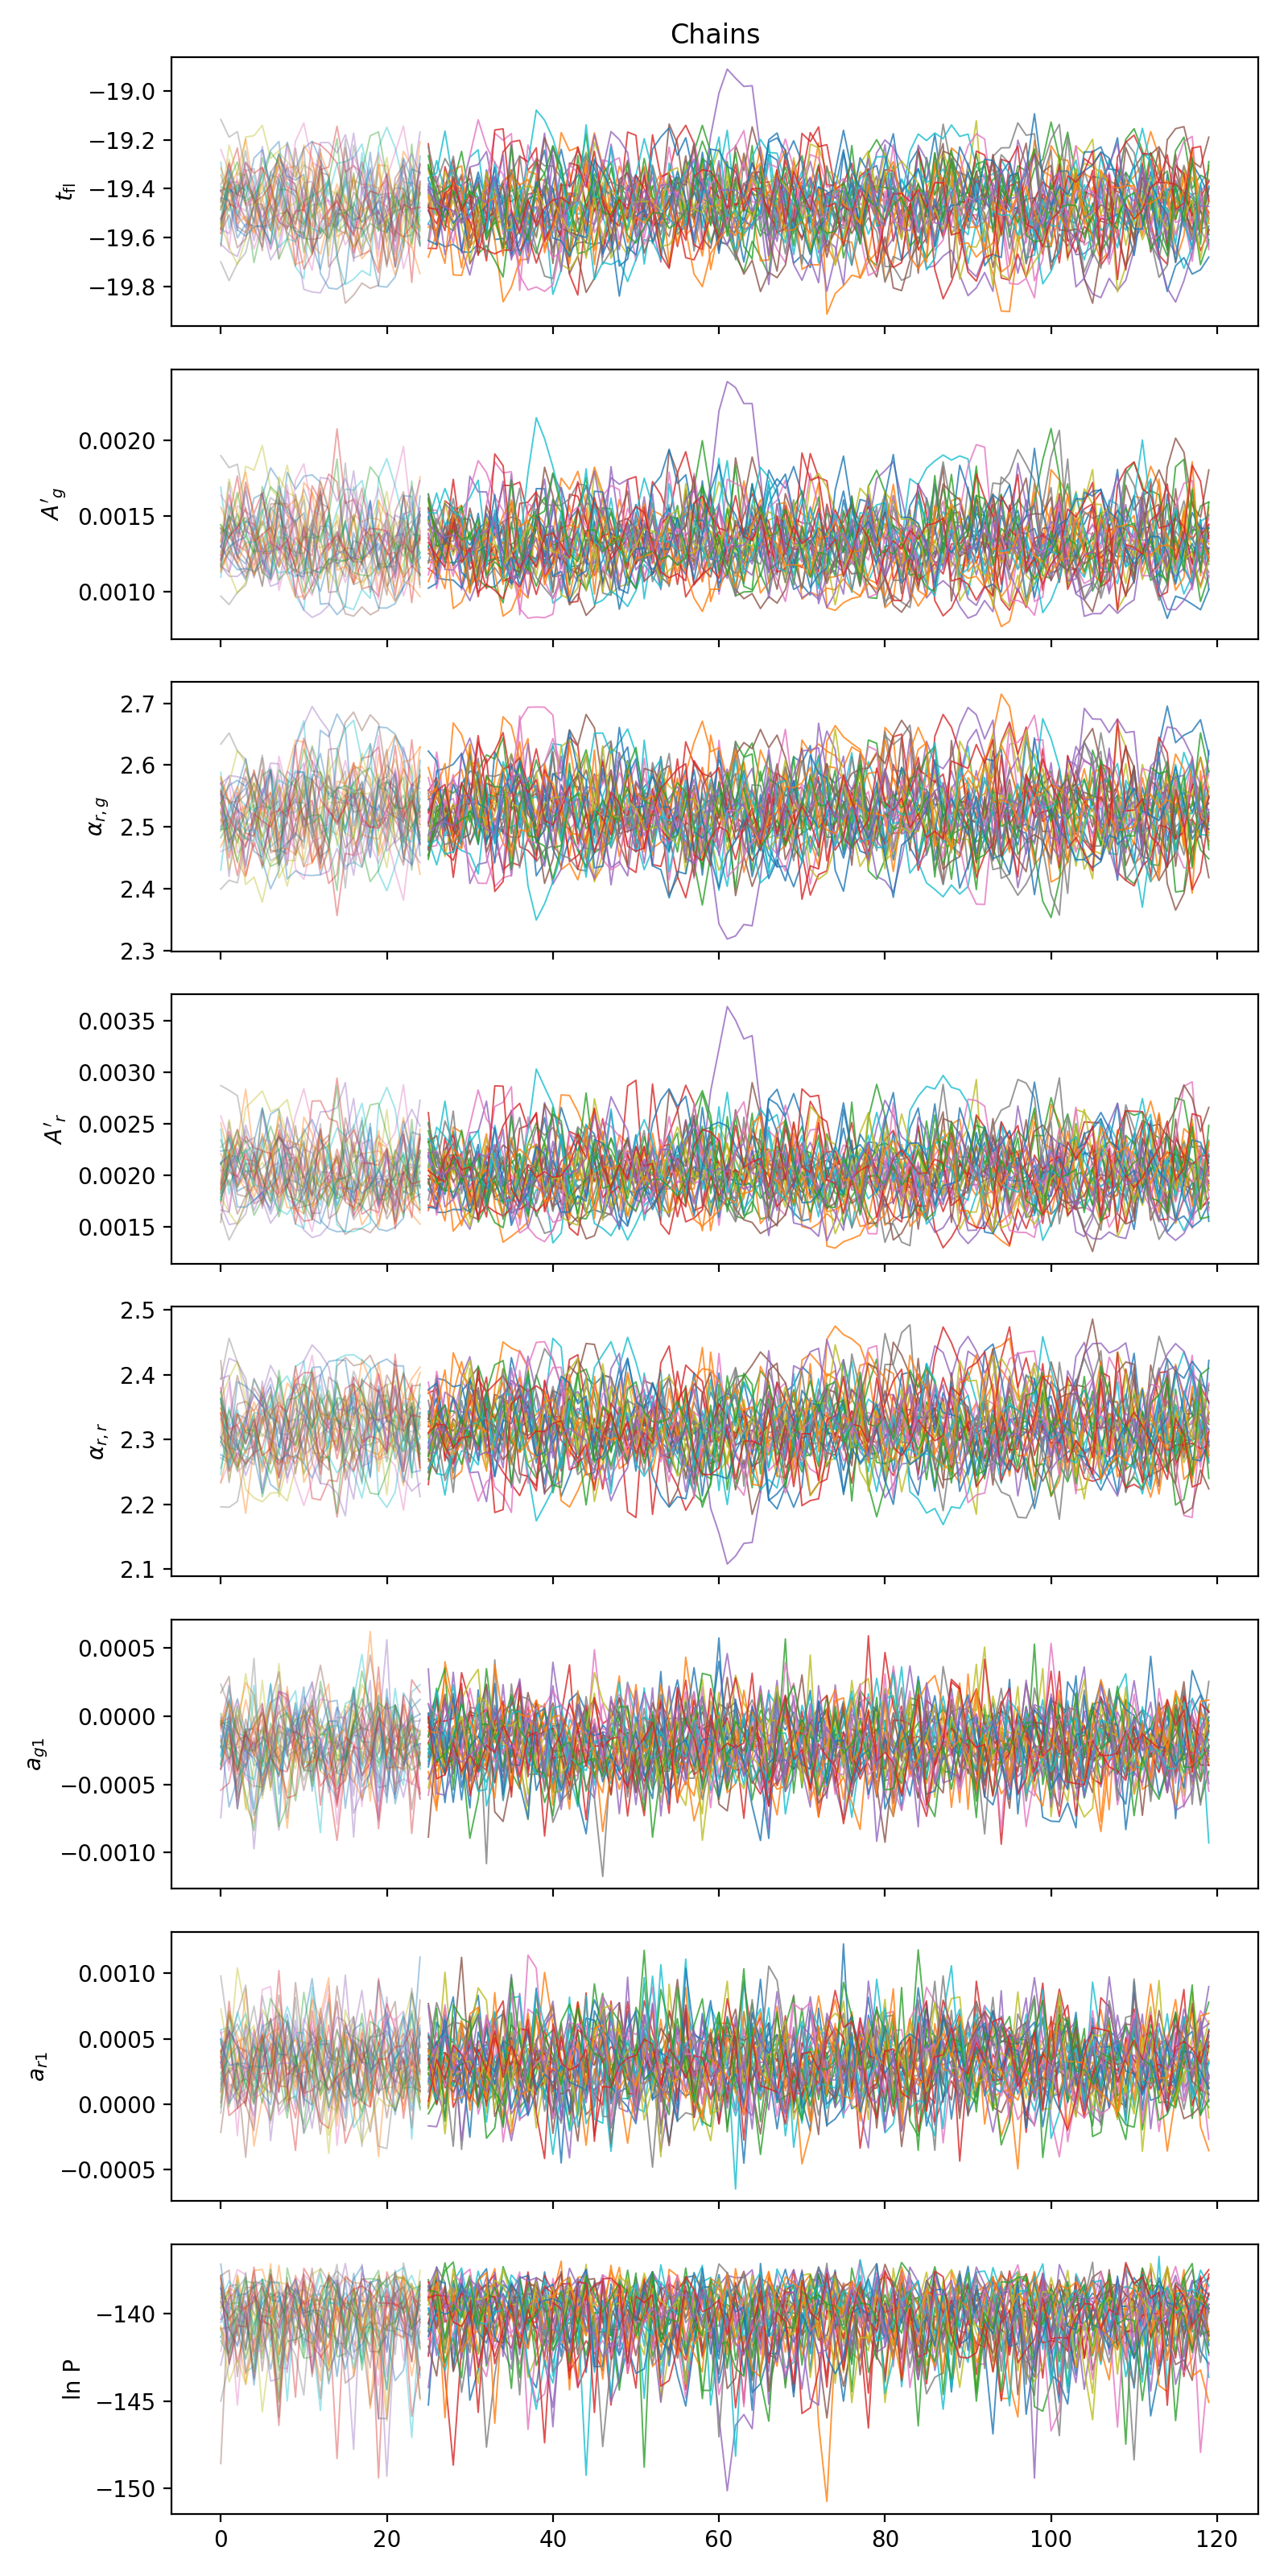

In [62]:
gr_paramsNames=[r'$t_\mathrm{fl}$', 
             r"$A'_g$", r'$\alpha_{r, g}$', 
             r"$A'_r$", r'$\alpha_{r, r}$']

baseline_list = []
g_fcqfid_idx = 1
r_fcqfid_idx = 1
for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
    filt = int(fcqfid % 10)
    if filt == 1:
        baseline_list.append('$a_{{g{}}}$'.format(g_fcqfid_idx))
        g_fcqfid_idx += 1
    elif filt == 2:
        baseline_list.append('$a_{{r{}}}$'.format(r_fcqfid_idx))
        r_fcqfid_idx += 1

gr_paramsNames = gr_paramsNames + baseline_list

plotChains(sampler, 25, gr_paramsNames, nplot=35)
plt.tight_layout()

<IPython.core.display.Javascript object>


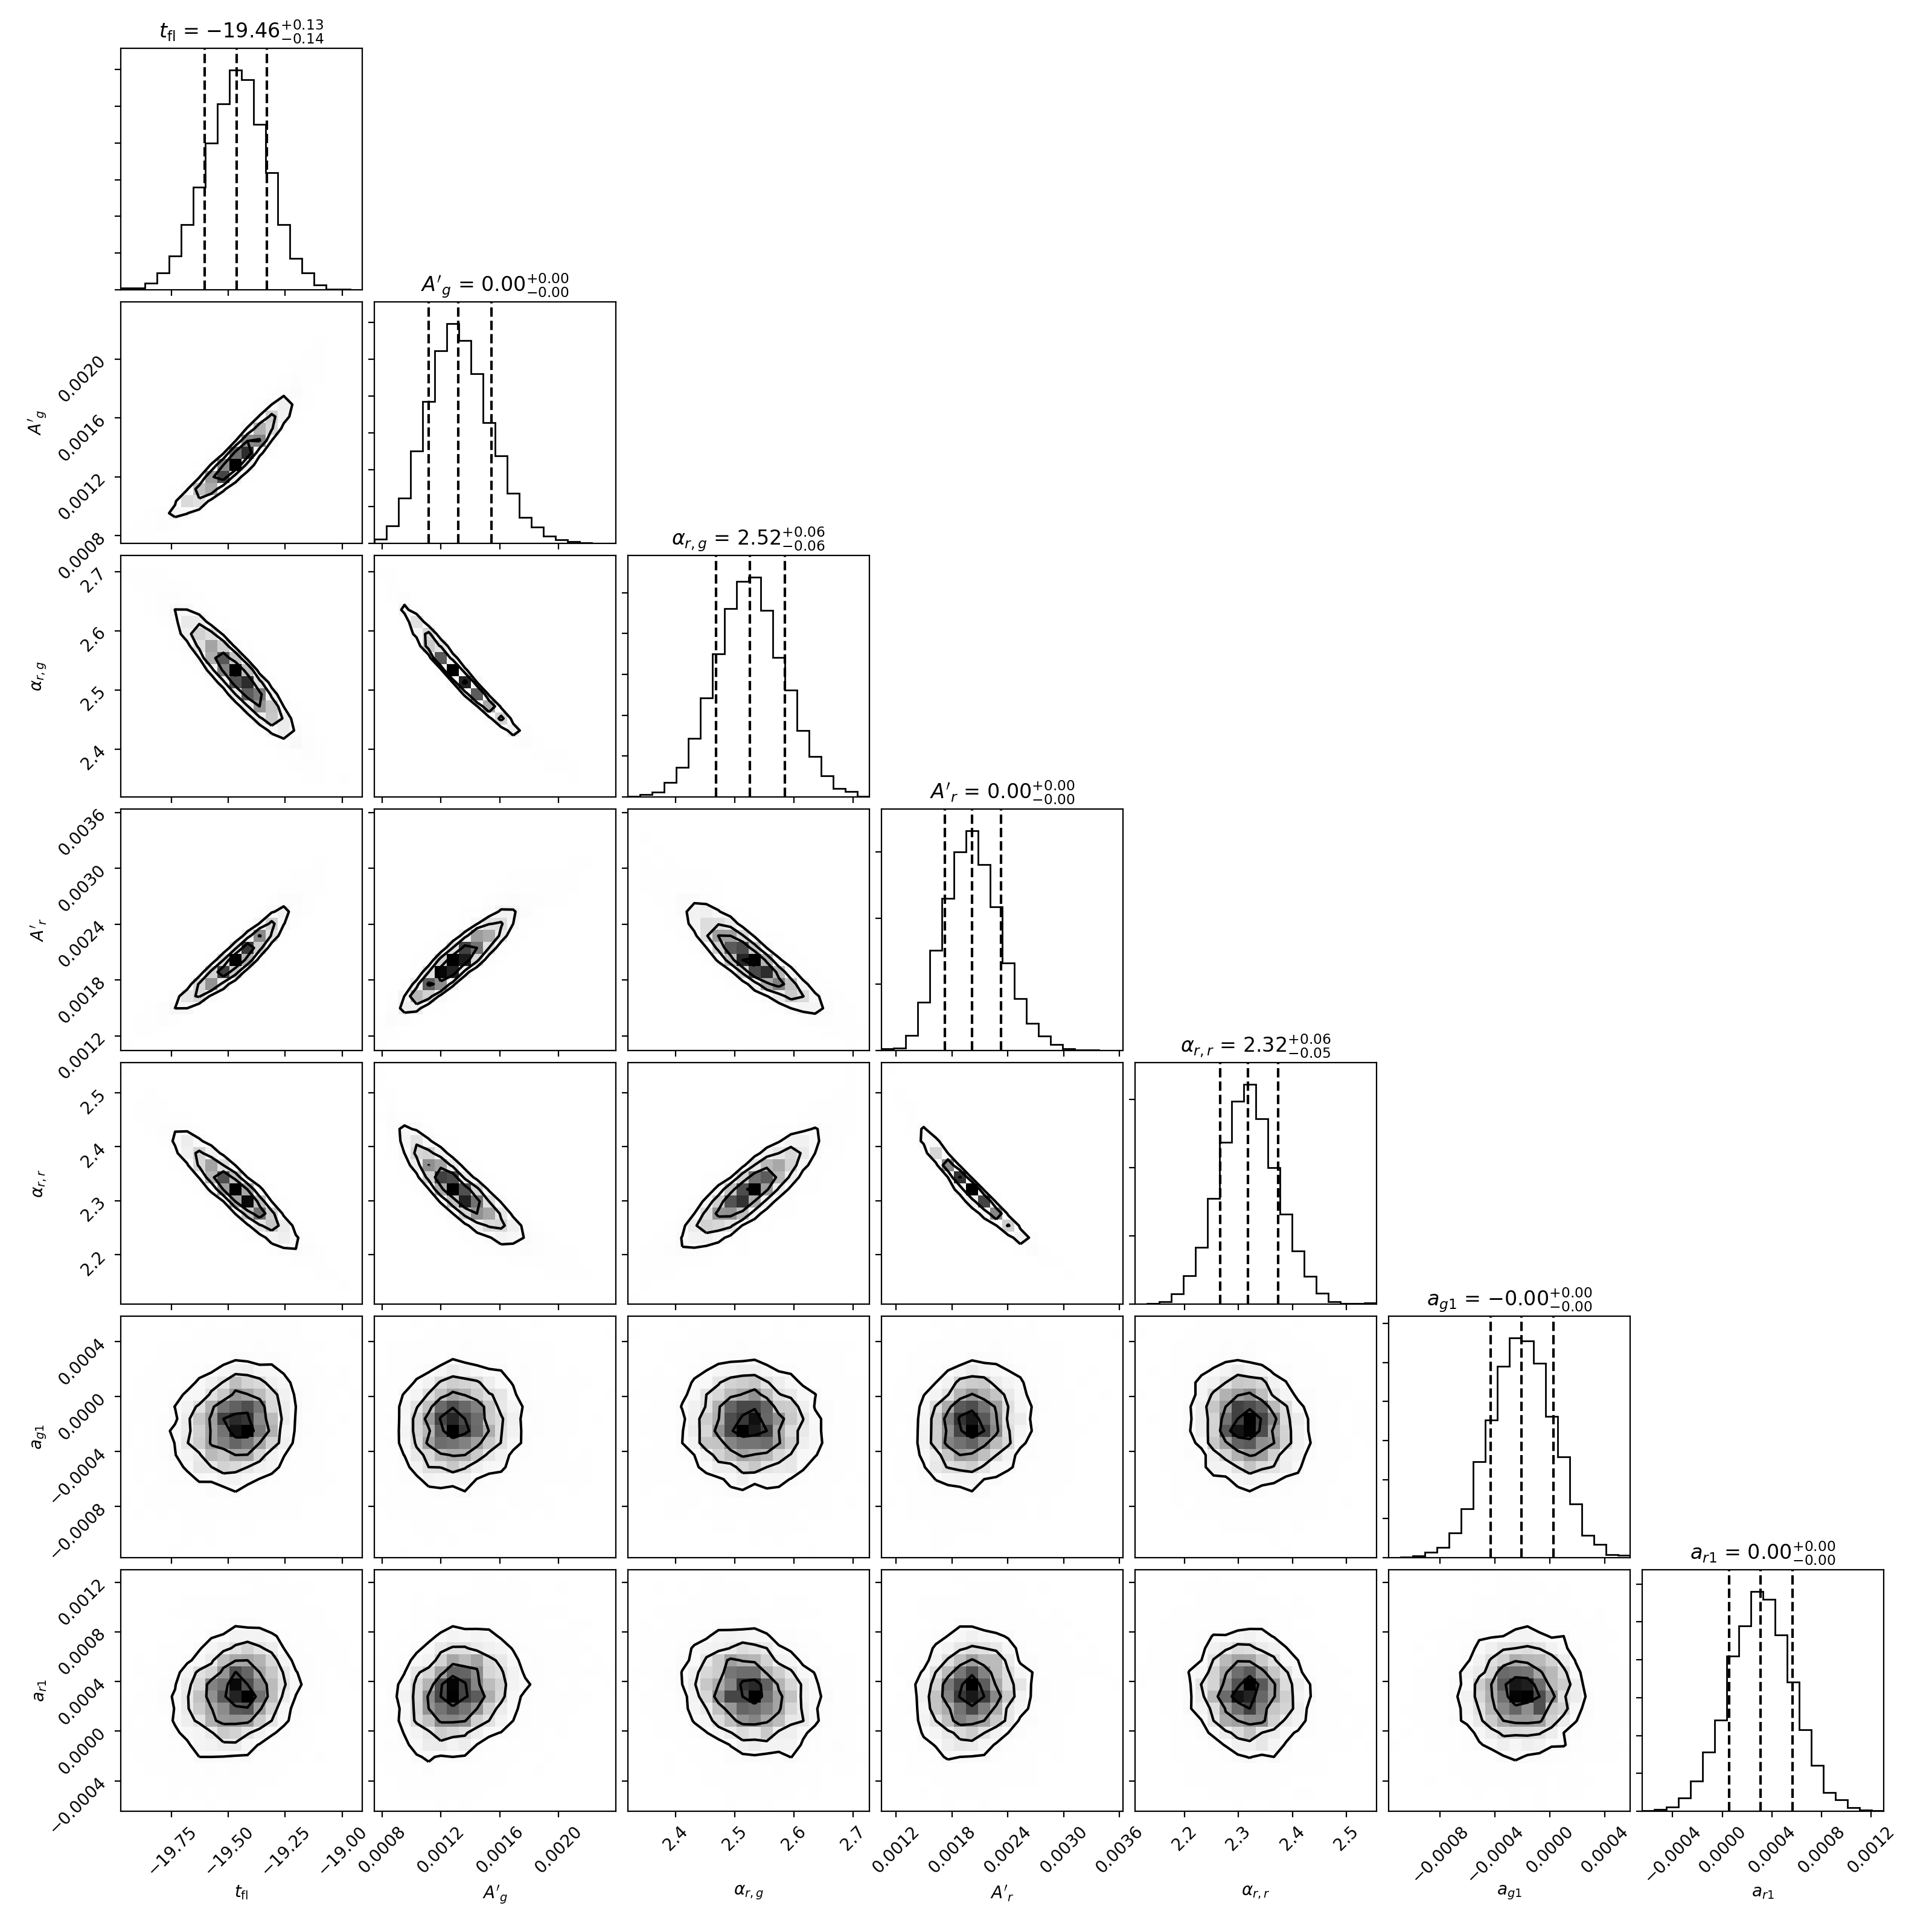

In [63]:
makeCorner(sampler, 25, gr_paramsNames)

## Inflating the uncertainties

According to the documentation from Frank Masci, the forced photometry procedure typically underestimates the uncertainties in the forced flux light curves. The best way to correct for this is to multiply by a constant multiplicative factor. We will experiment with that here. 

In [379]:
def lnlike_big_unc(theta, f, t, f_err):
    t_0, a, a_prime, alpha_r, f_sigma = theta

# kludge hack to keep the number of observations constant
#     n_obs = len(np.where((time < 0) & (flux <=0.2))[0])
#     n_remove = len(pre_turn_off) - n_obs    
#     obs_to_drop = np.random.choice(np.where(t < -50)[0], n_remove, replace=False)
#     t = np.delete(t, obs_to_drop)
#     f = np.delete(f, obs_to_drop)
#     f_err = np.delete(f_err, obs_to_drop)
    
    pre_exp = np.logical_not(t > t_0)
    model = 999999999*np.ones_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r
    assert np.all(model < 999999999),"fewer model values than flux values\n{}\n{}\na{}A'{}alpha{}f_sigma{}".format(model, time_term,a,a_prime,alpha_r,f_sigma)
    
    ln_l = -0.5*np.sum((f - model)**2 / ((f_sigma*f_err)**2)) - np.sum(np.log(f_sigma*f_err)) - 0.5*len(model)*np.log(np.sqrt(2*np.pi))
    return ln_l

def nll_big_unc(theta, flux, time, flux_err):
    return -1*lnlike_big_unc(theta, flux, time, flux_err)

#Define priors on parameters  
def lnprior_big_unc(theta):
    t_0, a, a_prime, alpha_r, f_sigma = theta
    if (-100 < t_0 < 0 and 0 < alpha_r < 1e8 and 
        -1e8 < a < 1e8 and 
        0 < a_prime < 1e8 and
        0 < f_sigma < 1e8):
        return 0.0
    return -np.inf

def lnposterior_big_unc(theta, flux, time, flux_err):
    lnp = lnprior_big_unc(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlike_big_unc(theta, flux, time, flux_err)
    if not np.isfinite(lnl):
        return -np.inf
    return lnl + lnp

## Fit one filter as a test

In [331]:
some_g = np.where(fcqfid_arr == 7970941)

In [332]:
t = time_rf[some_g]
f = flux[some_g]
f_err = flux_unc[some_g]

In [333]:
ml_res = minimize(nll_big_unc, g_guess, method='Powell', # Powell method does not need derivatives
                  args=(f, t, f_err))
ml_guess = ml_res.x
print(ml_guess)
print(nll_big_unc(ml_guess, f, t, f_err))

[-5.86091934e+00  1.56341997e-02  1.21229354e+00  1.67145259e+00
  1.64930478e+01 -4.97944031e+00]
-305.1666732234146


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


<IPython.core.display.Javascript object>


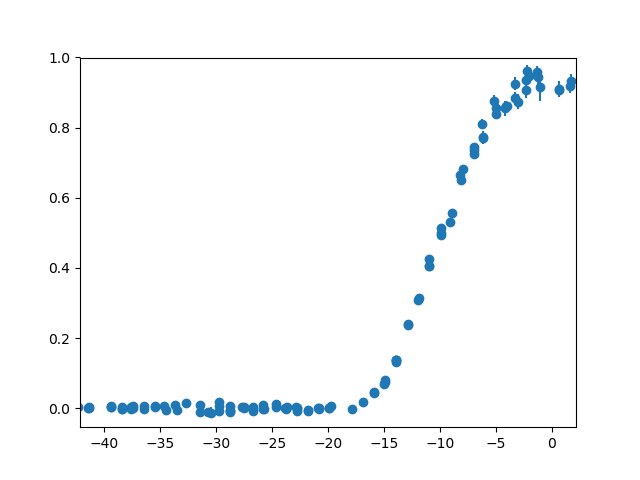

<ErrorbarContainer object of 3 artists>

In [334]:
    pre_exp = np.logical_not(t > ml_guess[0])
    model = 999999999*np.ones_like(f)
    model[pre_exp] = ml_guess[1]
    
    time_term = (t[~pre_exp] - ml_guess[0])
    model[~pre_exp] = ml_guess[1] + ml_guess[2] * (time_term)**alpha_r


plt.figure()
plt.errorbar(t, f*100, f_err*100, fmt='o')

In [320]:
lnl = np.empty(75)
for t_num, t_step in enumerate(np.linspace(-80,-5, 75)):
    g_guess = [t_step-4, 0.2, 1, 2, 1, t_step]
    lnl[t_num] = -1*nll_big_unc(g_guess, f, t, f_err)

<IPython.core.display.Javascript object>


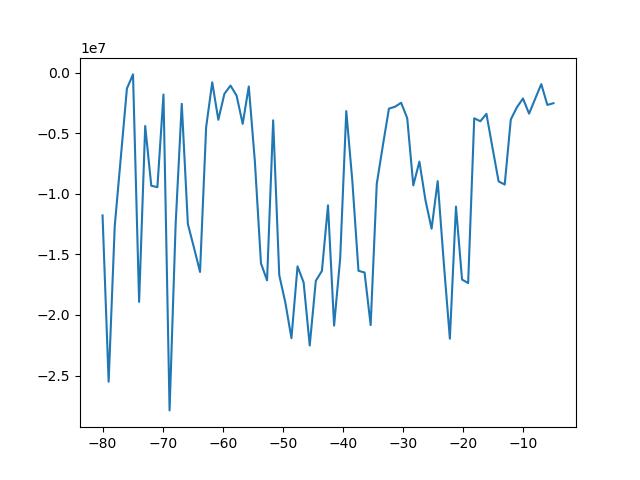

In [321]:
plt.figure()
plt.plot(np.linspace(-80,-5, 75), lnl)

In [387]:
def multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))

    if len(theta) != 1 + 2*n_filt + 2*n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')

    ln_l = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)

        theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + 2*fcqfid_num], 
                                 theta[2*filt-1], theta[2*filt],
                                 theta[2 + 2*n_filt + 2*fcqfid_num]])
        fcqfid_obs = np.where(fcqfid_arr == fcqfid)
        f_fcqfid = f[fcqfid_obs]
        t_fcqfid = t[fcqfid_obs]
        f_err_fcqfid = f_err[fcqfid_obs]
        ln_l += lnlike_big_unc(theta_fcqfid, f_fcqfid, t_fcqfid, f_err_fcqfid)
    
    return ln_l

def multifcqfid_nll_big_unc(theta, f, t, f_err, fcqfid_arr):
    return -1*multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr)

def multifcqfid_lnprior_big_unc(theta, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))

    if len(theta) != 1 + 2*n_filt + 2*n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')

    ln_p = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)

        theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + 2*fcqfid_num], 
                                 theta[2*filt-1], theta[2*filt],
                                 theta[2 + 2*n_filt + 2*fcqfid_num]])
        ln_p += lnprior_big_unc(theta_fcqfid)
    return ln_p

def multifcqfid_lnposterior_big_unc(theta, f, t, f_err, fcqfid_arr):
    lnp = multifcqfid_lnprior_big_unc(theta, fcqfid_arr)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr)
    if not np.isfinite(lnl):
        return -np.inf
    return lnl + lnp

In [388]:
multifcqfid_lnprior_big_unc(guess_0, fcqfid_arr)

0.0

In [390]:
rel_flux_cutoff = 0.5

time_rf = (lc_df['jdobs'].values - t0)/(1+z)
flux = lc_df['Fratio'].values
g_max = np.max(lc_df['Fratio'].iloc[g_obs].values)
r_max = np.max(lc_df['Fratio'].iloc[g_obs].values)
flux[g_obs] = flux[g_obs]/g_max
flux[r_obs] = flux[r_obs]/r_max
flux_unc = lc_df['Fratio_unc'].values
flux_unc[g_obs] = flux_unc[g_obs]/g_max
flux_unc[r_obs] = flux_unc[r_obs]/r_max
fcqfid_arr = lc_df['fcqfid'].values

t_fl = 18

cutoff_g = np.where((time_rf[g_obs] < 0) & 
                   (flux[g_obs] < rel_flux_cutoff))
t_cut_g = time_rf[g_obs][cutoff_g[0][-1]] + 0.5
early_g = np.where(time_rf[g_obs] < t_cut_g)
cutoff_r = np.where((time_rf[r_obs] < 0) & 
                   (flux[r_obs] < rel_flux_cutoff))
t_cut_r = time_rf[r_obs][cutoff_r[0][-1]] + 0.5
early_r = np.where(time_rf[r_obs] < t_cut_r)
early_obs = np.append(g_obs[0][early_g], r_obs[0][early_r])

# NOTE - the factor of 100
f_data = flux[early_obs]*100
t_data = time_rf[early_obs]
f_unc_data = flux_unc[early_obs]*100
fcqfid_data = fcqfid_arr[early_obs]

n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))
guess_0 = np.append([-t_fl] + [6e-1, 2]*n_filt,
                    [1,1]*len(np.unique(fcqfid_data)))
print(multifcqfid_nll_big_unc(guess_0, flux, time_rf, flux_unc, fcqfid_data))

469019.4306459917


In [391]:
# initialize near maximum-likelihood result
ml_res = minimize(multifcqfid_nll_big_unc, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(f_data, t_data, f_unc_data, fcqfid_data))
ml_guess = ml_res.x
print(ml_guess)
print(multifcqfid_nll_big_unc(ml_guess, f_data, t_data, f_unc_data, fcqfid_data))

[-21.65227827   0.50094278   1.96473425   0.40464105   1.95268408
   0.76468327   1.16844446  -0.78983251   0.86094746]
180.5876756978995


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


In [385]:
# simp_res = minimize(multifcqfid_nll_big_unc, guess_0, method='Powell', # Powell method does not need derivatives
#                     args=(f_data, t_data, f_unc_data, fcqfid_data))

guess_0=np.array([-17.8, 
                  1.3, 2, 
                  1.6, 1.8, 
                  0.1, 1.0, 
                  0.2, 1.1, 
                  0.3, 1.2, 
                  0.4, 1.3])

In [392]:
#################################################
###  sample with uncertainty multiplier term  ###
#################################################

nwalkers = 100
ndim = len(ml_guess)
nfac = [1e-4]*ndim

#initial position of walkers
pos = [ml_guess + ml_guess * nfac * np.random.randn(ndim) for i in range(nwalkers)]

filename = 'tmp.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, multifcqfid_lnposterior_big_unc, 
                                    args=(f_data, t_data, f_unc_data, fcqfid_data),
                                    pool=pool, backend=backend)
    max_samples = 10
    index = 0
    autocorr = np.empty(max_samples)
    old_tau = np.inf
    check_tau = 5
    for sample in sampler.sample(pos, iterations=max_samples, thin_by=250, progress=True):
        if sampler.iteration % check_tau:
            continue
        
        tstart = time.time()
        tau = sampler.get_autocorr_time(tol=0)
        tend = time.time()
        autocorr[index] = np.mean(tau)
        index += 1
        steps_so_far = index*check_tau
        print('''After {:d} steps, 
autocorrelation takes {:.3f} s ({} total FFTs)                
acceptance fraction = {:.4f}, and
tau = {}'''.format(steps_so_far, 
                   tend-tstart, nwalkers*ndim,
                   np.mean(sampler.acceptance_fraction), 
                   tau))

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

 51%|█████     | 1275/2500 [00:11<00:11, 108.27it/s]

After 5 steps, 
autocorrelation takes 0.041 s (900 total FFTs)                
acceptance fraction = 0.2960, and
tau = [0.25098507 0.33130096 0.32322293 0.30053272 0.27519163 0.37906626
 0.1606863  0.33874816 0.26049607]


100%|██████████| 2500/2500 [00:22<00:00, 109.46it/s]


After 10 steps, 
autocorrelation takes 0.039 s (900 total FFTs)                
acceptance fraction = 0.2610, and
tau = [0.965188   0.99259065 0.69914673 0.76502902 0.83047086 0.39177049
 0.56194736 0.51650626 0.59467283]


<IPython.core.display.Javascript object>


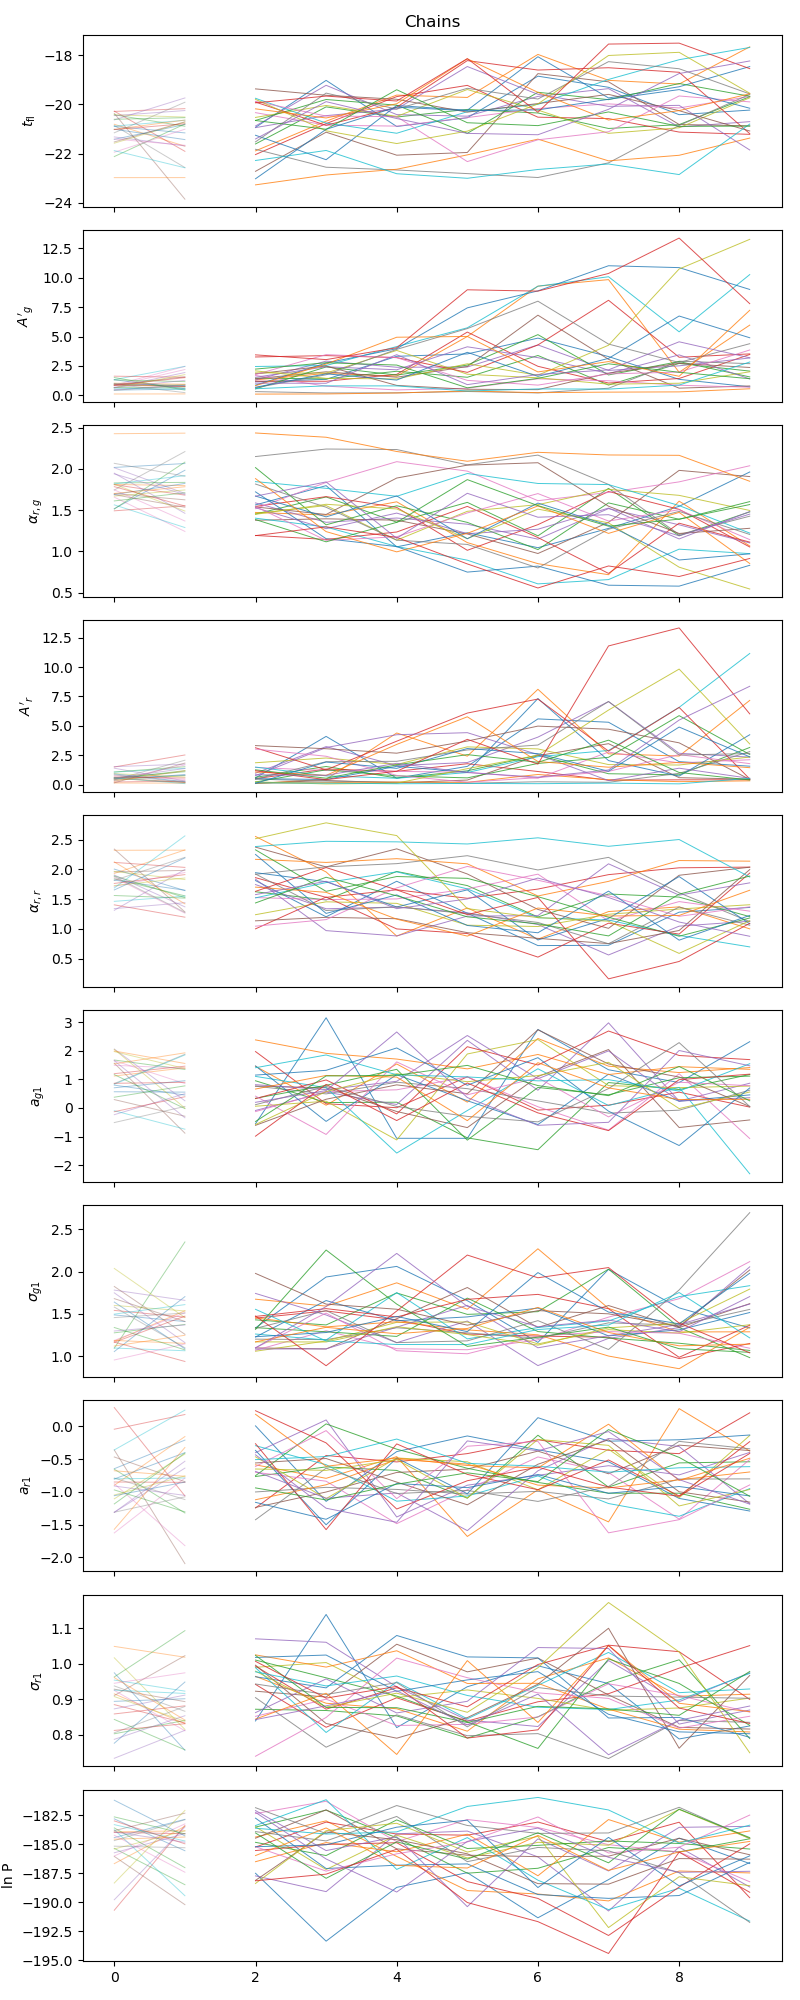

In [394]:
gr_paramsNames=[r'$t_\mathrm{fl}$', 
             r"$A'_g$", r'$\alpha_{r, g}$',
             r"$A'_r$", r'$\alpha_{r, r}$']

baseline_list = []
g_fcqfid_idx = 1
r_fcqfid_idx = 1
for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
    filt = int(fcqfid % 10)
    if filt == 1:
        baseline_list.append('$a_{{g{}}}$'.format(g_fcqfid_idx))
        baseline_list.append('$\sigma_{{g{}}}$'.format(g_fcqfid_idx))
        g_fcqfid_idx += 1
    elif filt == 2:
        baseline_list.append('$a_{{r{}}}$'.format(r_fcqfid_idx))
        baseline_list.append('$\sigma_{{r{}}}$'.format(r_fcqfid_idx))
        r_fcqfid_idx += 1

gr_paramsNames = gr_paramsNames + baseline_list

plotChains(sampler, 2, gr_paramsNames, nplot=25)
plt.tight_layout()

<IPython.core.display.Javascript object>


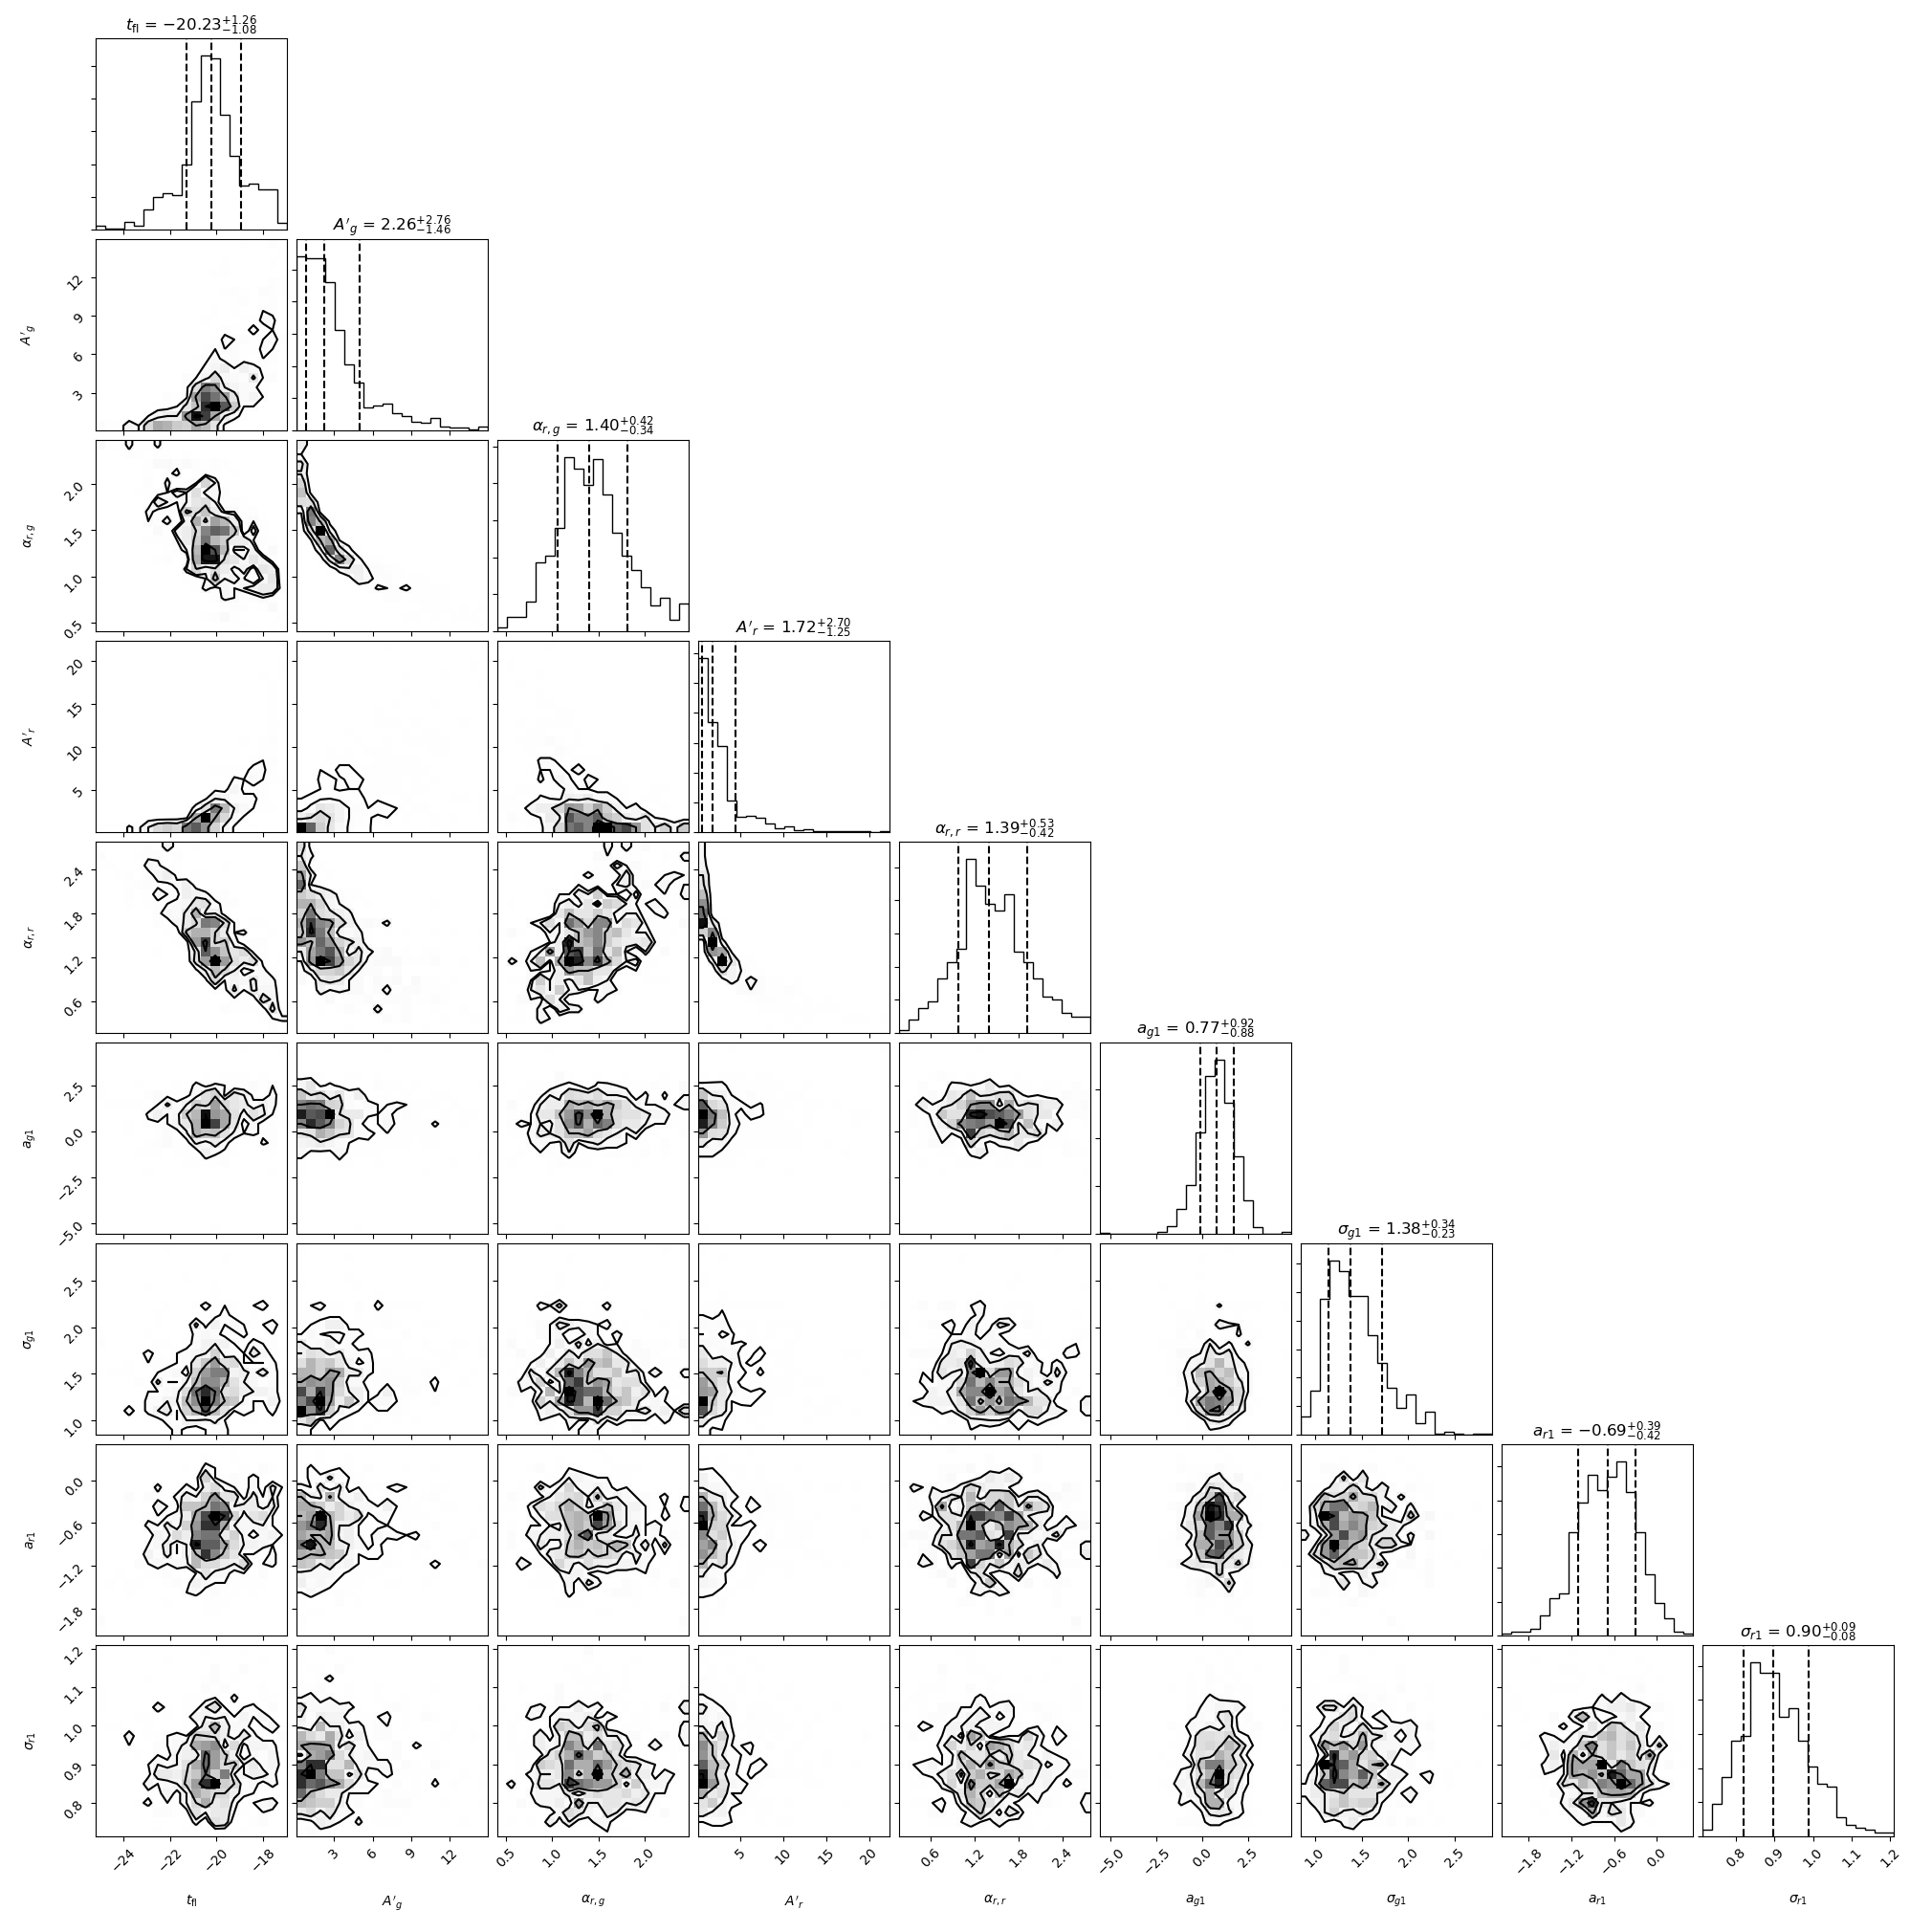

In [397]:
makeCorner(sampler, 2, gr_paramsNames)

In [155]:
guess_0 = np.append([-t_fl] + [6e-1, 2, -10]*n_filt,
                    [1,1]*len(np.unique(fcqfid_data)))
guess_0

array([-18. ,   0.6,   2. , -10. ,   0.6,   2. , -10. ,   1. ,   1. ,
         1. ,   1. ,   1. ,   1. ,   1. ,   1. ])

In [160]:
theta=[-18., 0.6, 2., -10., 0.9, 1.5, -10.1, 0.1, 1.0, 0.2, 1.1, 0.3, 1.2, 0.4, 1.3]

In [161]:
n_fcqid = len(np.unique(fcqfid_arr))
n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))

if len(theta) != 1 + 3*n_filt + 2*n_fcqid:
    raise RuntimeError('The correct number of parameters were not included')

ln_p = 0
for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
    filt = int(fcqfid % 10)

    theta_fcqfid = np.array([theta[0], theta[1 + 3*n_filt + 2*fcqfid_num], 
                             theta[3*filt-2], theta[3*filt-1],
                             theta[2 + 3*n_filt + 2*fcqfid_num],
                             theta[3*filt]])
    print(theta_fcqfid)

[-18.    0.1   0.6   2.    1.  -10. ]
[-18.    0.2   0.9   1.5   1.1 -10.1]
[-18.    0.3   0.6   2.    1.2 -10. ]
[-18.    0.4   0.9   1.5   1.3 -10.1]


In [154]:
len(guess_0)

11

In [87]:
if -30 < guess_0[0] < -22:
    print('yup')

### Notes on parallelization

It appears that using multiple cores does not provide a significant speed up in performance.

Below are some stored results and plots from running on quest with a different number of processors

In [67]:
# while not storing results
ncores = np.array([2, 4, 5, 5, 5, 5, 6, 6, 6, 7, 8, 10, 15, 20, 26])
tot_time = np.array([13993.50, 5192.63, 10233.39, 14400, 14400, 7692.74, 8240.39, 8080.49, 1522.20, 9541.60, 8611.35, 12488.45, 13651.56, 6197.13, 2715.01])
nsteps = np.array([1000000, 500000, 1000000, 516349, 528754, 1000000, 1000000, 1000000, 200000, 1000000, 1000000, 1000000, 1000000, 500000, 200000])
cpu_eff = np.array([87, 74, 70, 53, 53, 73, 66, 68, 64, 65, 65, 61, 40, 33, 21])
mem_use = np.array([6.47, 6.60, 6.85, 3.41, 3.41, 6.67, 6.95, 6.94, 2.07, 7.1, 7.11, 7.39, 8.02, 8.51, 4.41])
mem_eff = np.array([22, 22, 24, 11.65, 11.65, 23, 24, 24, 7, 25, 25, 25, 27, 29, 5])

In [31]:
d_ncores = np.array([3, 4, 6, 8])
d_tot_time = np.array([10699.64, 4964.63, 9989.93, 7693.95])
d_nsteps = np.array([750000, 500000, 1000000, 1000000])
d_cpu_eff = np.array([78, 80, 67, 68])
d_mem_use = np.array([6.94, 7.06, 7.60, 8.15])
d_mem_eff = np.array([24, 24, 26, 28])

In [78]:
# using thin_by = 100
ncores = np.array([3, 4, 5, 6, 7, 8])
tot_time = np.array([10657.04, 12455.27, 9726.25, 6716.09, 10743.65, 10812.20])
nsteps = np.array([900000, 800000, 800000, 500000, 800000, 600000])
cpu_eff = np.array([63, 47, 54, 45, 40, 33])
mem_use = np.array([1, 1, 1, 1, 1, 1])
mem_eff = np.array([2, 2, 3, 3, 3, 4])

In [4]:
# using thin_by = 500
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 10])
tot_time = np.array([1559.88, 1455.93, 1050.50, 965.94, 890.68, 851.89, 991.74, 1488.30])
nsteps = np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000])
cpu_eff = np.array([81, 61, 63, 64, 62, 59, 57, 59])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 1])
mem_eff = np.array([1, 2, 2, 2, 3, 3, 4, 4])

In [74]:
# rerun with no thin_by and no storage
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 12, 16])
tot_time = np.array([2287.98, 1241.54, 1038.46, 894.54, 893.08, 783.83, 1362.39, 1464.66, 2121.96])
nsteps = np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000])
cpu_eff = np.array([66, 75, 70, 66, 62, 64, 62, 54, 38])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 1.5, 2])
mem_eff = np.array([1, 2, 2, 3, 3, 3, 4, 5, 7])

In [16]:
# using thin_by = 500 and ZTF18abxxssh (702 obs)
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 10])
tot_time = np.array([1554.22, 1016.15, 845.92, 794.48, 670.84, 863.17, 983.31, 1179.83])
nsteps = np.array([50000])
cpu_eff = np.array([80, 79, 74, 70, 68, 62, 60, 60])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 1])
mem_eff = np.array([1, 2, 2, 2, 3, 3, 4, 4])

In [14]:
# using thin_by = 500 and ZTF18aaqnrum (110 obs)
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 12])
tot_time = np.array([1288.44, 1063.12, 966.28, 747.86, 779.72, 728.91, 859.55, 1290.64])
nsteps = np.array([100000])
cpu_eff = np.array([77, 70, 65, 66, 62, 62, 61, 51])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 2])
mem_eff = np.array([1, 2, 2, 2, 3, 3, 4, 5])

In [18]:
# using thin_by = 500 and ZTF18aailmnv (506 obs)
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 12])
tot_time = np.array([2215.58, 1778.02, 1425.01, 1364.36, 1173.55, 1453.12, 1668.66, 2102.35])
nsteps = np.array([100000])
cpu_eff = np.array([87, 78, 76, 69, 67, 62, 61, 55])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 2])
mem_eff = np.array([1, 2, 2, 2, 3, 3, 4, 5])

In [ ]:
# using thin_by = 500 
ncores = np.array([])
tot_time = np.array([])
nsteps = np.array([])
cpu_eff = np.array([])
mem_use = np.array([])
mem_eff = np.array([])

<IPython.core.display.Javascript object>


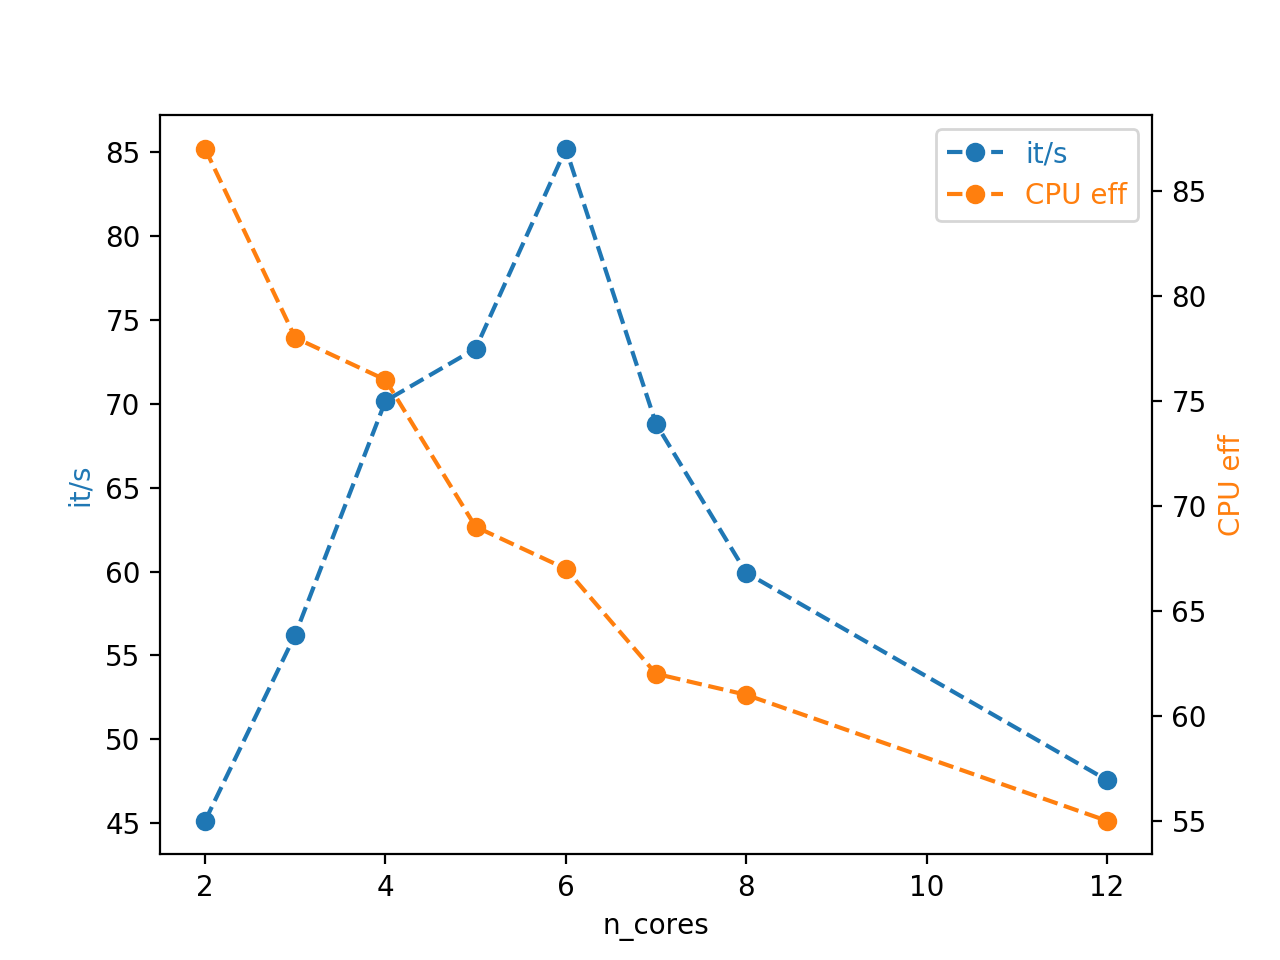

In [19]:
from mpl_toolkits.axes_grid1 import host_subplot
plt.figure()
host = host_subplot(111)

par = host.twinx()

host.set_xlabel("n_cores")
host.set_ylabel("it/s")
par.set_ylabel("CPU eff")

p1, = host.plot(ncores, nsteps/tot_time, 'o--', label="it/s")
p2, = par.plot(ncores, cpu_eff, 'o--', label="CPU eff")
# p1_d, = host.plot(d_ncores, d_nsteps/d_tot_time, 
#                   'd-', c = 'C0', mfc='none', mec='C0', mew=1)
# p1_2, = par.plot(d_ncores, d_cpu_eff, 
#                   'd-', c = 'C1', mfc='none', mec='C1', mew=1)

leg = plt.legend()

host.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()


<IPython.core.display.Javascript object>


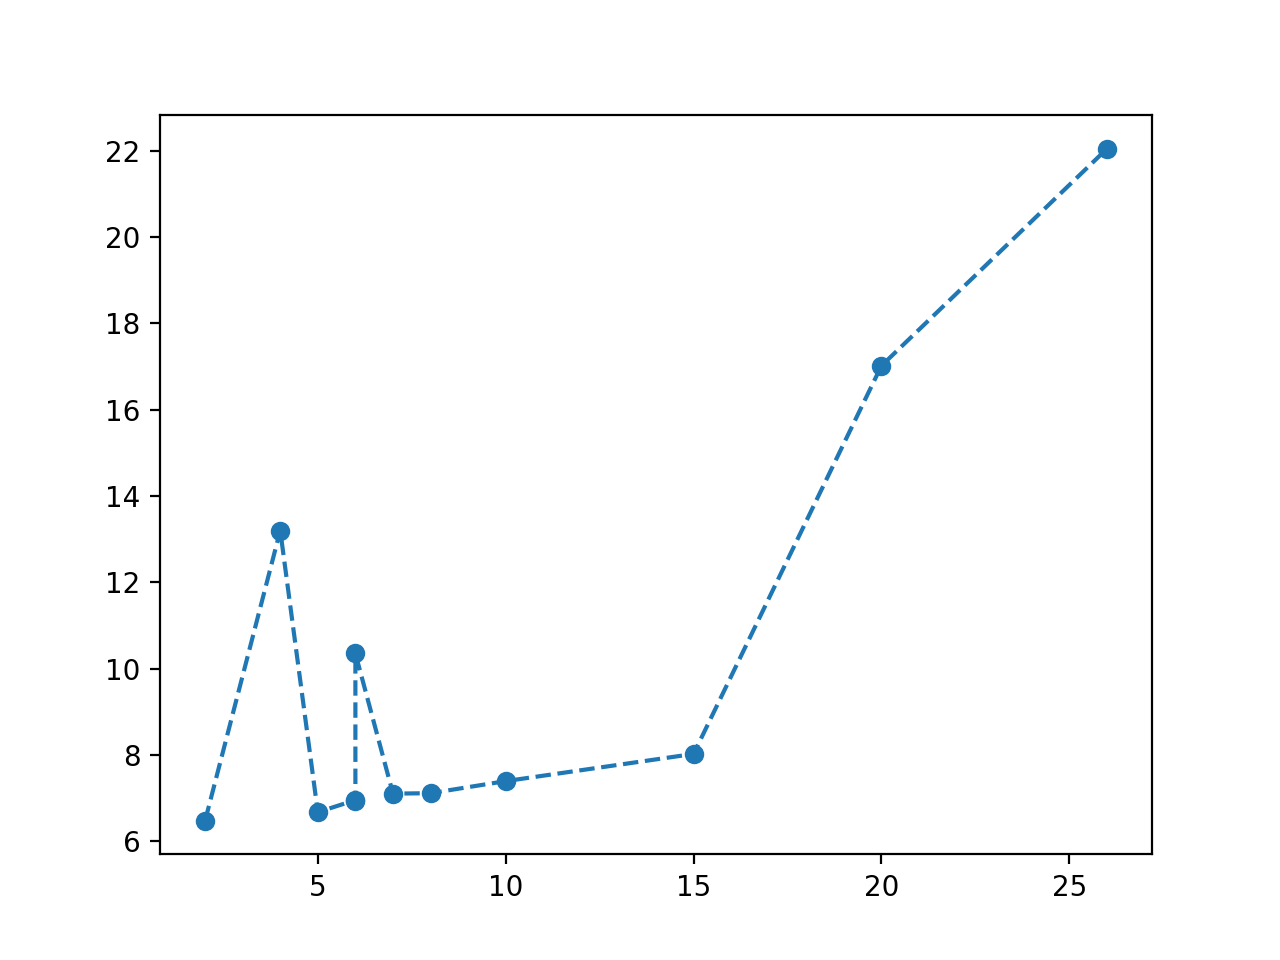

In [70]:
fig, ax = plt.subplots()
ax.plot(ncores, mem_use*1e6/nsteps, 'o--')

In [94]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.get_chain(discard=nburn, flat=True)
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          truths=truths, plot_datapoints=False)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          show_titles=True, plot_datapoints=False)
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    selected_walkers = np.random.choice(range(sampler.get_chain().shape[1]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax

paramsNames=[r'$t_\mathrm{fl}$', 
             '$a_g$', r"$A'_g$", r'$\alpha_{r, g}$']